In [1]:
pip install seaborn



[notice] A new release of pip is available: 24.1.2 -> 25.0.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install plotly




[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [3]:
pip install mplcursors



[notice] A new release of pip is available: 24.1.2 -> 25.0.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import sqlite3
import os
import mplcursors

In [26]:
# Dynamically determine the base project root directory
current_dir = os.getcwd()  # Current working directory (from which the notebook is run)
project_root = os.path.abspath(os.path.join(current_dir, '..','Healthcare_ETL_Project'))

# Dynamically locate the database path in the 'db' folder within the project root
db_dir = os.path.join(project_root, "db")
db_path = os.path.join(db_dir, "healthcare_data.db")

# Ensure the database exists at the expected location
if not os.path.exists(db_path):
    raise FileNotFoundError(f"Database not found at {db_path}")

# Connect to the SQLite database
conn = sqlite3.connect(db_path)
print(f"Database connection successful: {db_path}")


Database connection successful: /Users/avinashmacbookair/Documents/TREND_Health_Partners_3/Healthcare_ETL_Project/db/healthcare_data.db


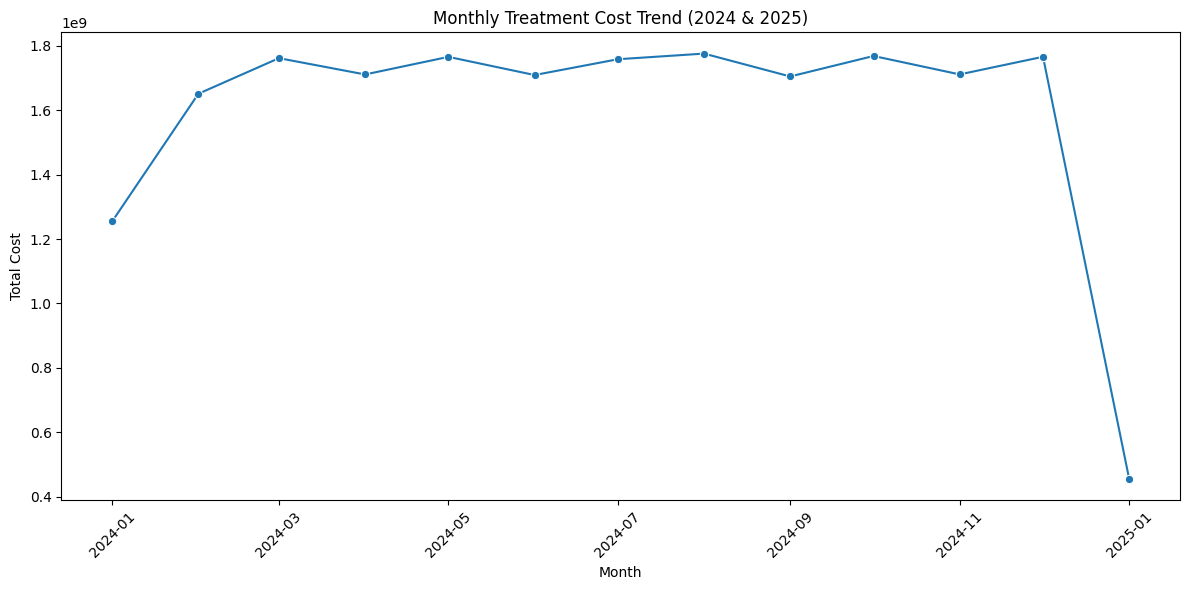

In [27]:
#Monthly Treatment Cost Trend (2024 & 2025)
query = """
WITH MonthlyCost AS (
    SELECT 
        strftime('%Y-%m', Outcome_Date) AS YearMonth,
        SUM(Cost) AS Total_Cost
    FROM TREATMENT
    GROUP BY YearMonth
    ORDER BY YearMonth
)
SELECT * FROM MonthlyCost;
"""
df = pd.read_sql_query(query, conn)
df['YearMonth'] = pd.to_datetime(df['YearMonth'])

plt.figure(figsize=(12,6))
sns.lineplot(data=df, x='YearMonth', y='Total_Cost', marker='o')
plt.title('Monthly Treatment Cost Trend (2024 & 2025)')
plt.xlabel('Month')
plt.ylabel('Total Cost')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/var/folders/8p/tcwj_1fn4fdfxbkcw9km0ffh0000gn/T/ipykernel_86292/742291565.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='State', y='Total_Cost', palette='crest')


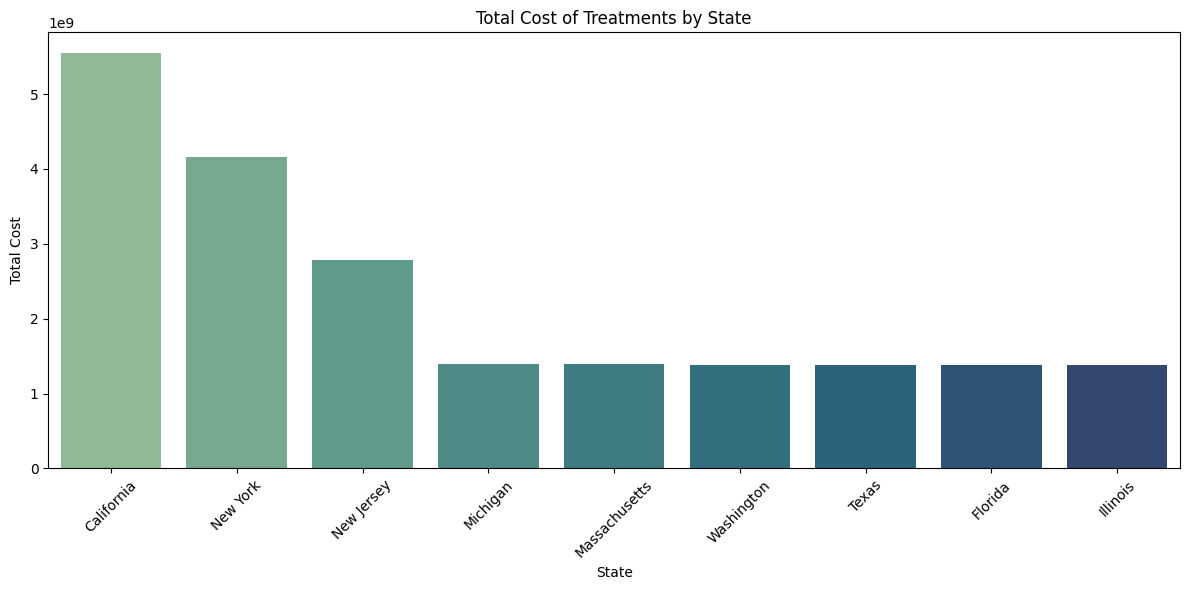

In [31]:
#Total Cost of Treatments by State
query = """
SELECT 
    L.State, 
    SUM(T.Cost) AS Total_Cost
FROM TREATMENT T
JOIN LOCATION L ON T.Location_ID = L.Location_ID
GROUP BY L.State
ORDER BY Total_Cost DESC;
"""
df = pd.read_sql_query(query, conn)

plt.figure(figsize=(12,6))
sns.barplot(data=df, x='State', y='Total_Cost', palette='crest')
plt.title('Total Cost of Treatments by State')
plt.xlabel('State')
plt.ylabel('Total Cost')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



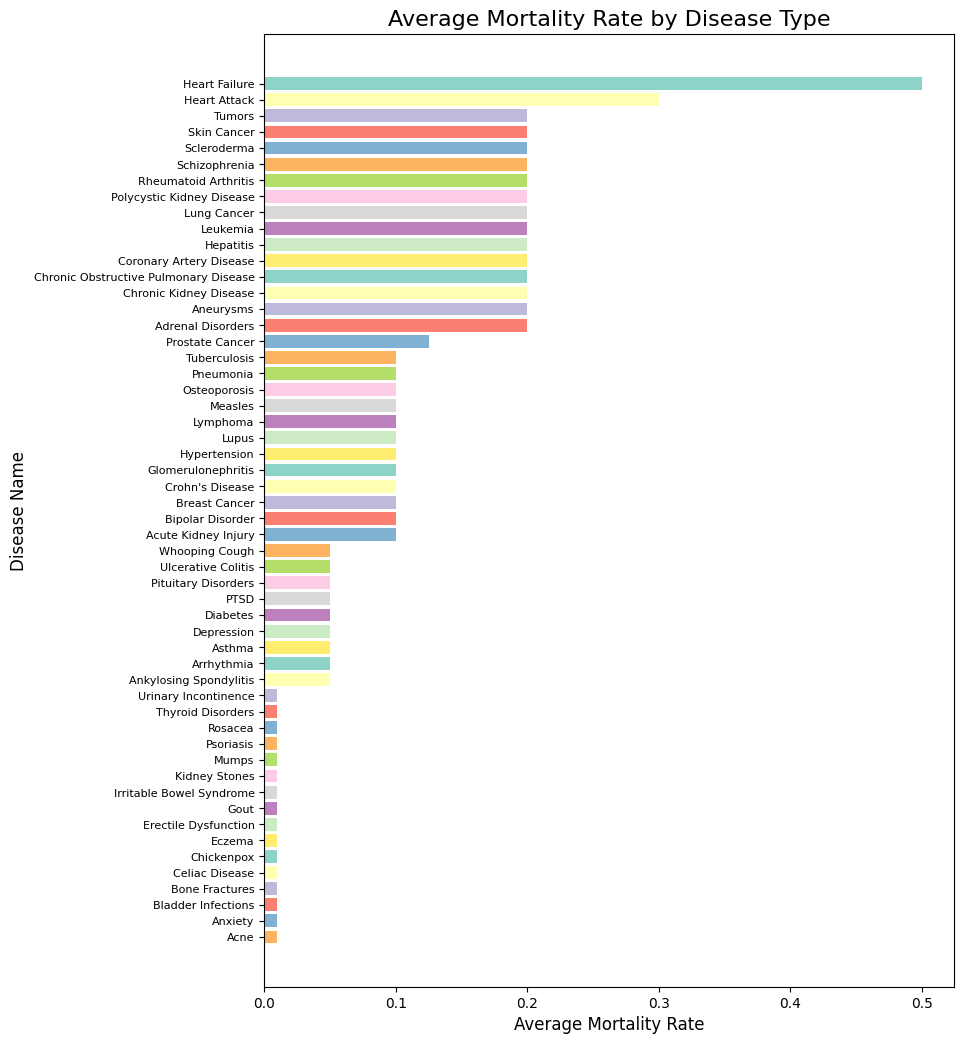

In [50]:
# Query to get the mortality rate based on disease name
query = """
SELECT d.Name, AVG(d.Mortality_Rate) AS avg_mortality_rate
FROM DISEASE d 
GROUP BY d.Name
ORDER BY avg_mortality_rate DESC; 
"""

# Execute the query and fetch the results into a pandas dataframe
df = pd.read_sql_query(query, conn)

if df.empty:
    print("No data available for the mortality rate visualization.")
else:
    # Create a taller figure for better spacing
    plt.figure(figsize=(10, 0.2 * len(df)))  # dynamic height based on number of diseases

    # Plot the horizontal bar chart
    bars = plt.barh(df['Name'], df['avg_mortality_rate'], color=sns.color_palette('Set3', len(df)))

    # Title and labels
    plt.title('Average Mortality Rate by Disease Type', fontsize=16)
    plt.xlabel('Average Mortality Rate', fontsize=12)
    plt.ylabel('Disease Name', fontsize=12)

    # Improve y-axis label spacing
    plt.yticks(fontsize=8)  # smaller font for better separation
    plt.gca().invert_yaxis()  # highest mortality rate at the top
    plt.tight_layout(pad=2.0)  # extra padding for clarity

    # Add tooltips
    cursor = mplcursors.cursor(bars, hover=True)
    cursor.connect("add", lambda sel: sel.annotation.set_text(f'{df["Name"].iloc[sel.index]}: {df["avg_mortality_rate"].iloc[sel.index]:.2f}%'))

    # Show the plot
    plt.show()



/var/folders/8p/tcwj_1fn4fdfxbkcw9km0ffh0000gn/T/ipykernel_86292/3330574131.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Outcome_Weekend_Flag', y='Treatment_Count', palette='crest')


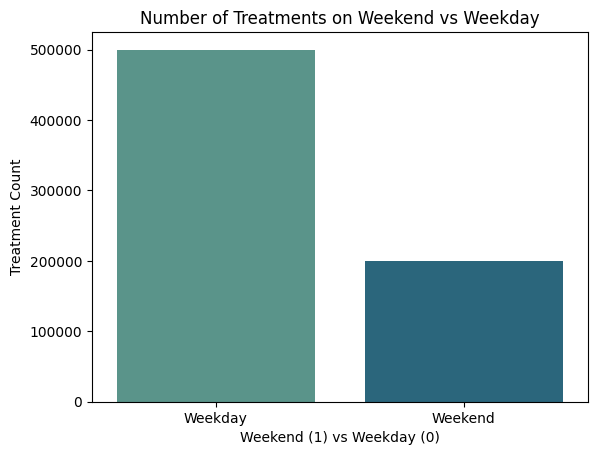

In [32]:
# Number of Treatments on Weekend vs Weekday
query = """
SELECT 
    Outcome_Weekend_Flag, 
    COUNT(Treatment_ID) AS Treatment_Count
FROM TREATMENT
GROUP BY Outcome_Weekend_Flag
ORDER BY Outcome_Weekend_Flag;
"""
df = pd.read_sql_query(query, conn)

# Plotting the data
sns.barplot(data=df, x='Outcome_Weekend_Flag', y='Treatment_Count', palette='crest')
plt.title('Number of Treatments on Weekend vs Weekday')
plt.xlabel('Weekend (1) vs Weekday (0)')
plt.ylabel('Treatment Count')
plt.xticks([0, 1], ['Weekday', 'Weekend'], rotation=0)
plt.show()

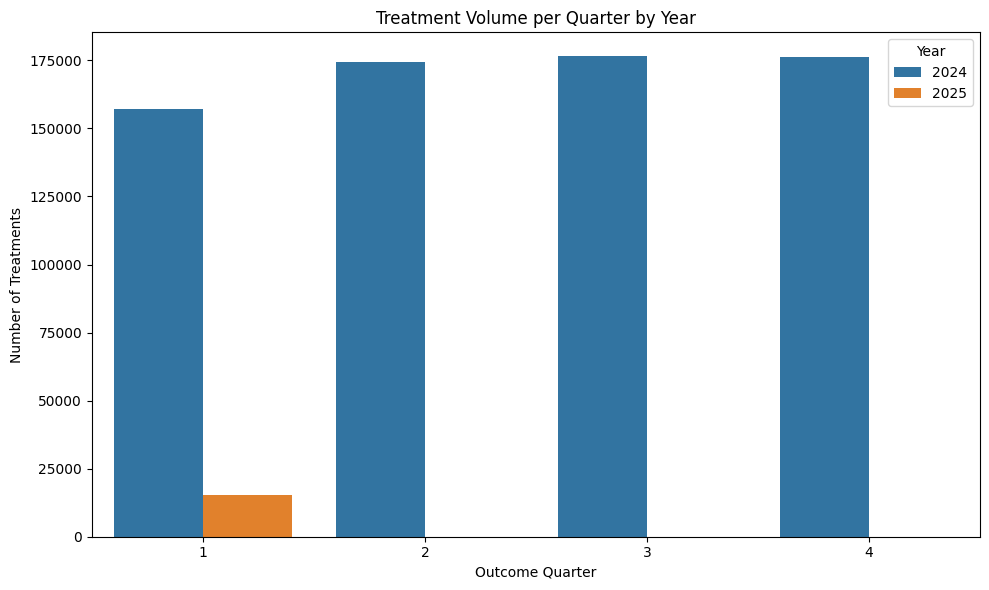

In [33]:
#Quarterly Treatment Volume by Year
query = """
SELECT 
    strftime('%Y', Outcome_Date) AS Year,
    Outcome_Quarter,
    COUNT(*) AS Treatment_Count
FROM TREATMENT
GROUP BY Year, Outcome_Quarter
ORDER BY Year, Outcome_Quarter;
"""
df = pd.read_sql_query(query, conn)

plt.figure(figsize=(10,6))
sns.barplot(data=df, x='Outcome_Quarter', y='Treatment_Count', hue='Year')
plt.title('Treatment Volume per Quarter by Year')
plt.xlabel('Outcome Quarter')
plt.ylabel('Number of Treatments')
plt.tight_layout()
plt.show()


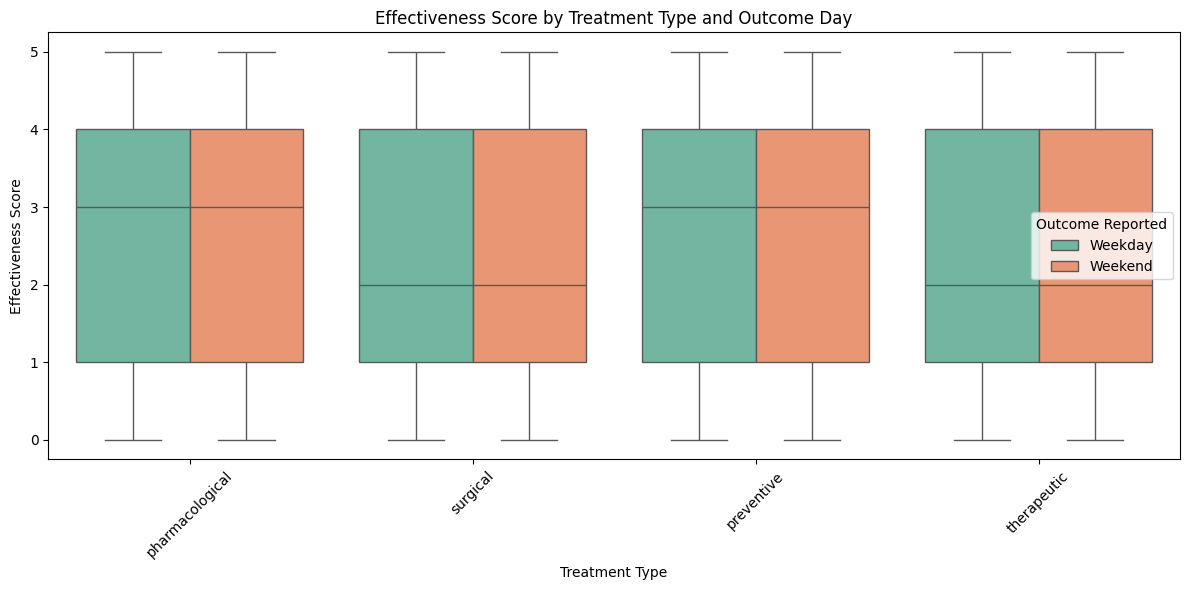

In [34]:
# Effectiveness Score by Treatment Type and Outcome Day
query = """
SELECT 
    Type,
    Effectiveness_Score,
    Outcome_Weekend_Flag
FROM TREATMENT
WHERE Effectiveness_Score IS NOT NULL
"""
df = pd.read_sql_query(query, conn)

# Clean and prepare
df['Outcome_Weekend_Flag'] = df['Outcome_Weekend_Flag'].replace({0: 'Weekday', 1: 'Weekend'})

# Plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Type', y='Effectiveness_Score', hue='Outcome_Weekend_Flag', palette='Set2')
plt.title('Effectiveness Score by Treatment Type and Outcome Day')
plt.xlabel('Treatment Type')
plt.ylabel('Effectiveness Score')
plt.legend(title='Outcome Reported')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


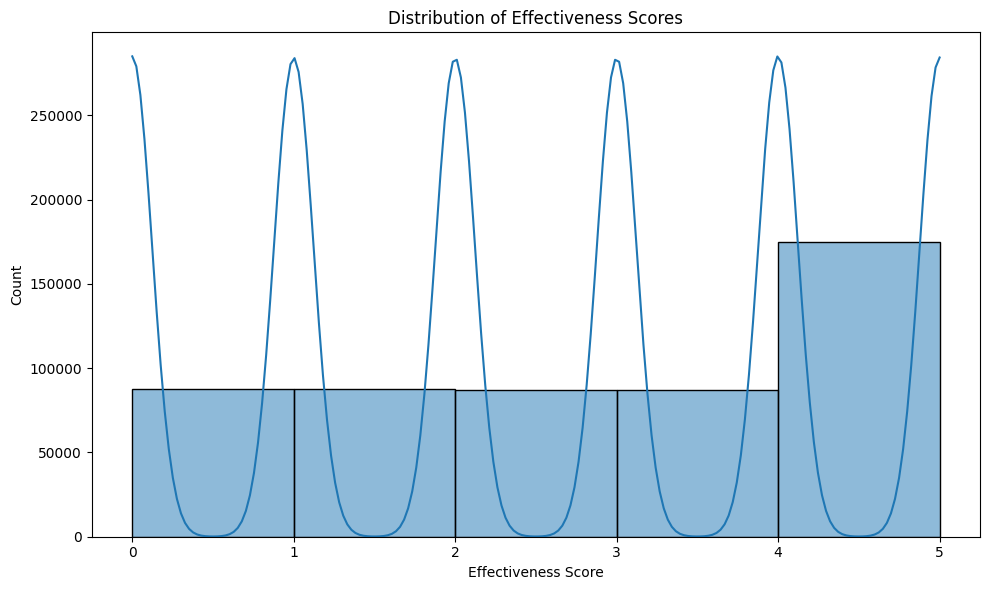

In [35]:
#Effectiveness Score Distribution
query = """
SELECT Effectiveness_Score
FROM TREATMENT
WHERE Effectiveness_Score IS NOT NULL;
"""
df = pd.read_sql_query(query, conn)

plt.figure(figsize=(10,6))
sns.histplot(df['Effectiveness_Score'], bins=5, kde=True)
plt.title('Distribution of Effectiveness Scores')
plt.xlabel('Effectiveness Score')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


In [34]:
conn.close()